In [118]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import f1_score
import seaborn as sns
import joblib



In [119]:
# List files in the data directory to check the correct filename
print(os.getcwd())
# __file__ is not defined in Jupyter notebooks; use os.getcwd() instead
dir_path = os.getcwd()

print("Current Directory:", dir_path)
dir_path = dir_path.replace('src\\kepler', 'data')
print("Data Directory:", dir_path)
df = pd.read_csv(dir_path + '/processed_toi.csv')

c:\Users\downe\RightGoodProgrammers\src\kepler
Current Directory: c:\Users\downe\RightGoodProgrammers\src\kepler
Data Directory: c:\Users\downe\RightGoodProgrammers\data


In [120]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['tfopwg_disp_APC', 'tfopwg_disp_CP', 'tfopwg_disp_FA','tfopwg_disp_FP', 'tfopwg_disp_KP', 'tfopwg_disp_PC']])

In [121]:
target_cols = ['tfopwg_disp_APC', 'tfopwg_disp_CP', 'tfopwg_disp_FA', 'tfopwg_disp_FP', 'tfopwg_disp_KP', 'tfopwg_disp_PC']
x_train = train_df.drop(columns=target_cols)
y_train = train_df[target_cols]
x_test = test_df.drop(columns=target_cols)
y_test = test_df[target_cols]

print("\nTraining set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)


Training set shape: (6162, 37) (6162, 6)
Testing set shape: (1541, 37) (1541, 6)


In [122]:

# Initialize scaler if it doesnt exist
for file in os.listdir(dir_path.replace('data', 'models')):
    print(file)
    if 'toiscaler' in file:
        scaler = joblib.load(os.path.join(dir_path.replace('data', 'models'), file))
        break
    else:
        scaler = StandardScaler()

# Fit and transform training data (learns mean and std)
x_train_scaled = scaler.fit_transform(x_train)

# Transform test data (using training mean/std)
x_test_scaled = scaler.transform(x_test)

# Convert back to DataFrames to keep column names
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

# Show before/after scaling for first feature
print("Before scaling:")
print(f"Mean: {x_train.iloc[:,0].mean():.2f}")
print(f"Std: {x_train.iloc[:,0].std():.2f}")

print("\nAfter scaling:")
print(f"Mean: {x_train_scaled.iloc[:,0].mean():.2f}")
print(f"Std: {x_train_scaled.iloc[:,0].std():.2f}")

confusion_matrix.png
k2panda_model.pkl
keplerkepler_rf_best.pkl
toiscaler.joblib
Before scaling:
Mean: 43163.25
Std: 24867.81

After scaling:
Mean: 0.00
Std: 1.00


In [123]:
y_train = y_train.idxmax(axis=1).str.replace('tfopwg_disp_', '').str.strip()
y_test = y_test.idxmax(axis=1).str.replace('tfopwg_disp_', '').str.strip()


for file in os.listdir(dir_path.replace('data', 'models')):
    if 'toilabelencoder' in file:
        label_encoder = joblib.load(os.path.join(dir_path.replace('data', 'models'), file))
        break
    else:
        label_encoder = LabelEncoder()

        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test)

        print("\nClasses:", label_encoder.classes_)
        print("Training Label Distribution:",pd.Series(y_train).value_counts())


Classes: ['APC' 'CP' 'FA' 'FP' 'KP' 'PC']
Training Label Distribution: 5    3743
3     958
1     547
4     466
0     370
2      78
Name: count, dtype: int64

Classes: [0 1 2 3 4 5]
Training Label Distribution: 5    3743
3     958
1     547
4     466
0     370
2      78
Name: count, dtype: int64

Classes: [0 1 2 3 4 5]
Training Label Distribution: 5    3743
3     958
1     547
4     466
0     370
2      78
Name: count, dtype: int64

Classes: [0 1 2 3 4 5]
Training Label Distribution: 5    3743
3     958
1     547
4     466
0     370
2      78
Name: count, dtype: int64

Classes: [0 1 2 3 4 5]
Training Label Distribution: 5    3743
3     958
1     547
4     466
0     370
2      78
Name: count, dtype: int64

Classes: [0 1 2 3 4 5]
Training Label Distribution: 5    3743
3     958
1     547
4     466
0     370
2      78
Name: count, dtype: int64


In [124]:
number_of_trees = [int(x) for x in np.linspace(start = 20, stop = 400, num = 12)]
best_f1 = 0
best_rf = None
for file in os.listdir(dir_path.replace('data', 'models')):
    if 'toirandomforest' in file:
        best_rf = joblib.load(os.path.join(dir_path.replace('data', 'models'), file))
        y_pred = best_rf.predict(x_test_scaled)
        best_f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Loaded existing model with F1 Score: {best_f1:.4f}")
        break
    
for n_trees in number_of_trees:
    print(f"\nTraining Random Forest with {n_trees} trees...")
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1)
    rf.fit(x_train_scaled, y_train)
    
    y_pred = rf.predict(x_test_scaled)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_rf = rf
        print("New best model found!")


Training Random Forest with 20 trees...
F1 Score: 0.6541
New best model found!

Training Random Forest with 54 trees...
F1 Score: 0.6588
New best model found!

Training Random Forest with 89 trees...
F1 Score: 0.6569

Training Random Forest with 123 trees...
F1 Score: 0.6528

Training Random Forest with 158 trees...
F1 Score: 0.6586

Training Random Forest with 192 trees...
F1 Score: 0.6528

Training Random Forest with 227 trees...
F1 Score: 0.6552

Training Random Forest with 261 trees...
F1 Score: 0.6573

Training Random Forest with 296 trees...
F1 Score: 0.6541

Training Random Forest with 330 trees...
F1 Score: 0.6565

Training Random Forest with 365 trees...
F1 Score: 0.6547

Training Random Forest with 400 trees...
F1 Score: 0.6539


Prediction Accuracy: 69.95%


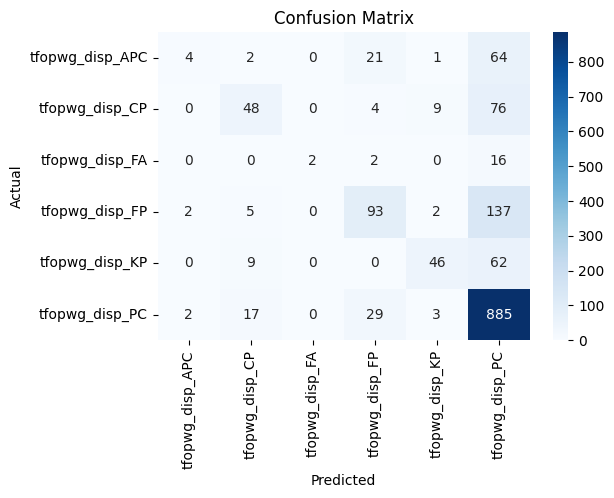

<Figure size 640x480 with 0 Axes>

In [136]:
from matplotlib import pyplot as plt


mapping = {'tfopwg_disp_APC': 'APC', 'tfopwg_disp_CP': 'CP', 'tfopwg_disp_FA': 'FA', 'tfopwg_disp_FP': 'FP', 'tfopwg_disp_KP': 'KP', 'tfopwg_disp_PC': 'PC'}
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {accuracy * 100:.2f}%')
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_cols, yticklabels=target_cols)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plt.savefig(dir_path.replace('data', 'models') + '/toi_confusion_matrix.png')

In [126]:
current_dir = os.getcwd()
model_dir = current_dir.replace('src\\kepler', 'models\\')
joblib.dump(best_rf, model_dir + 'toi_rf_best.pkl')

['c:\\Users\\downe\\RightGoodProgrammers\\models\\toi_rf_best.pkl']